In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [29]:
# This cell should be the only one that changes, as this is where the dataset and corresponding sample information
date = '122421'
df = pd.read_excel('122421PjyuenLipidomics1_6.xlt', header=12) # Make sure to change header depending on your data file
# Make sure sample names is in same order as data
I500 = ['I5001','I5002','I5003']
I1000 = ['I10001','I10002','I10003']

sample_names = I1000+I500
sample_names_plotting = sample_names # Change if you want plots in a different order than sample names

groups = {'I1000':I1000, 'I500':I500}

hue_order_list = ['I500','I1000']


num_fatty_acid_columns = 3 # Change to 4 if there is an FA4 column

### Functions

In [30]:
def strfilter(func, s: str) -> str:
    """
    Return a string containing all characters in s such that func(s) is true.
    """
    return ''.join(i for i in s if func(i))
def get_sat(s):
    new = ''
    i = 0
    while not str.isdecimal(s[i]):
        i += 1
    while i < len(s) and str.isdecimal(s[i]):
        new += s[i]
        i += 1
    return new
def average_samples(data):
    for k, v in groups.items():
        if len(v) > 1:
            data[k] = data.loc[:, v].mean(axis=1)
    return data
def name_map(name: str) -> str:
    for k, v in groups.items():
        if name in v:
            return k
    return name

In [31]:
# constants
phospholipids = ['PC', 'PE', 'LPC', 'LPE', 'PS', 'LPS', 'PG', 'LPG', 'PA',
                 'LPA', 'PI', 'LPI', 'PIP', 'PIP2', 'PIP3', 'CL', 'PGP',
                 'PPA', 'CDP-DG', 'SM']
atom_masses = {'C': 12.011, 'N': 14.007, 'H': 1.008, 'O': 15.999, 'P': 30.974}
tails_1 = {i: 1 for i in ['LPC','LPE','LPS','LPG','LPA','LPI']}
tails_2 = {i:2 for i in ['PC','PE','PS','PA','PI','PIP','PIP2','PIP3','PGP','PPA', 'CDP-DG','SM']}
tails_3_4 = { 'TG':3,'CL':4}

from itertools import chain
tails = dict(chain.from_iterable(d.items() for d in (tails_1, tails_2, tails_3_4)))

sample_columns = ['Area[c-' + str(sample + 1) + ']' for sample in range(0, len(sample_names))]
fa_columns = ['FA' + str(i) for i in range(1, num_fatty_acid_columns + 1)]

In [32]:
def sum_areas(data):
    """
    Sum the areas corresponding to each fatty acid.
    
    Args:
        data: a pandas dataframe with lipids as index and columns corresponding to
        the fatty acids in each lipid and the area calculated for that lipid in each sample
    Returns:
        a new pandas dataframe with fatty acids as index and columns for each sample, where the
        value at df.loc[fatty_acid, sample] is the sum of the areas for that sample in rows of
        data where fatty_acid is one of the fatty acids in the lipid, counting multiple times if
        the fatty acid appears multiple times in that lipid.
    """
    # we treat '(12:2p)' and '(12:2)' as the same fatty acid
    data.loc[:, fa_columns] = data.loc[:, fa_columns].applymap(standardize_formula)
    dfs = [data[sample_columns].groupby(data[i]).sum()
           for i in fa_columns]
    return pd.concat(dfs).groupby(level=0).sum()

In [33]:
def remove_wrong_fatty_acid_counts(data):
    """
    If the  fatty acid count does not match the lipid class' expected fatty acid count, the row will be dropped
    """
    data['right_fa_count'] = False
    for i, row in data.iterrows():
        try:
            if tails[row['Class']] == num_fatty_acid_columns - row[fa_columns].isna().sum():
                data.loc[i, 'right_fa_count'] = True
        except KeyError:
            data.loc[i, 'right_fa_count'] = True
    return data[data['right_fa_count']]

In [34]:
def how_much_saturated(formula: str) -> str:
    """
    From a formula of the form '(14:2)', extract the number of double bonds and return
    the saturation level ('saturated', 'mono', or 'poly').
    """
    double_bonds = int(formula.split(':')[1].split(' ')[0])
    if double_bonds == 0:
        return 'saturated'
    elif double_bonds == 1:
        return 'mono'
    else:
        return 'poly'

In [35]:
def standardize_formula(formula: str) -> str:
    """
    Transform formulas of the form '(12:20p)' to the form '12:20'.
    """
    if pd.isna(formula):
        return formula
    try:
        a, b = formula.split(':')
    except ValueError:
        return formula[1:-1]
    a = get_sat(a)
    b = get_sat(b)
    # a = strfilter(str.isdecimal, a)
    # b = strfilter(str.isdecimal, b)
    return a + ':' + b

In [36]:
def rename_parts(data):
    """
    Replace the column names 'Area[c-1]', 'Area[c-2]', etc with names corresponding to each sample
    """

    data.columns = sample_names
    return data

In [37]:
def prepare_for_graphing(data):
    """
    Reshape a dataframe for easier graphing.

    Concatenate the columns of a dataframe, adding a column named 'orig_sample' with the original column name,
    a column named 'sample' with the sample condition, and a column named 'kind' with the values of the index.
    """
    dfs = []
    for sample in sample_names:
        a = data.loc[:, sample] \
                .to_frame() \
                .rename(columns={sample: 'fraction'})
        a['orig_sample'] = sample
        dfs.append(a)
    combined = pd.concat(dfs)
    combined['kind'] = combined.index
    combined['sample'] = combined['orig_sample'].map(name_map)
    return combined

In [38]:
def graph_fatty_acids(data, title: str):
    """
    Generate a heat map and bar graph showing the fraction of the most common fatty acids in each sample.
    """
    largest_rows = data \
                    .sum(axis=1) \
                    .sort_values(ascending=False) \
                    .iloc[:15] \
                    .index
    a = data / data.sum()
    a = a.loc[largest_rows, sample_names]
    fig = plt.figure(figsize=(15, 5))
    
    # heatmap
    plt.subplot(1, 2, 1)
    
    ax = sns.heatmap(a[sample_names_plotting], vmin=0, vmax=.35)
    ax.set_title(title)
    ax.set_xlabel('sample')
    
    # bar graph
    plt.subplot(1, 2, 2)
    a = prepare_for_graphing(a)
    ax = sns.barplot(x='kind', y='fraction', hue='sample', hue_order = hue_order_list,data=a, ci=None)
    plt.ylim(0, .35)
    ax.set_title(title)
    ax.set_xlabel('fatty acid')
    fig.autofmt_xdate() # Tilt and align the x-axis labels

In [39]:
def graph_saturation(data, title: str):
    """
    Generate a bar graph showing the fraction of saturated fats in each condition.
    """
    a = data.groupby([how_much_saturated(x) for x in data.index]).sum()
    a = a / a.sum()
    plt.ylim(0, .8)
    a = prepare_for_graphing(a)
    ax = sns.barplot(x='sample', y='fraction', hue='kind',data=a, ci=None)
    ax.set_title(title + ' saturated / monounsaturated / polyunsaturated')

In [40]:
def run_pca(data):
    data_pca = data.T.iloc[0:15]

    # normalize to mean 0 and variance 1
    scaler = StandardScaler() 
    scaler.fit(data_pca)
    scaled_data = scaler.transform(data_pca)
    
    # project data onto PCA dimensions
    pca = PCA(n_components = 2)
    pca.fit(scaled_data)
    components = pca.transform(scaled_data)
    
    loading_vectors = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=data_pca.columns)
    pca_values_df = pd.DataFrame(data = components, columns = ['PC1', 'PC2'])
    pca_values_df['sample'] = data_pca.index
    return loading_vectors, pca_values_df

In [41]:
def graph_pca(data, title: str):
    fig = plt.figure(figsize = (8,8))
    data['sample'] = data['sample'].map(name_map)
    ax = sns.scatterplot(x='PC1', y='PC2', hue='sample', hue_order = ['7d', 'I0','I120','I500','I1000'],data=data, s=100)
    ax.set_xlabel('PC1', fontsize = 15)
    ax.set_ylabel('PC2', fontsize = 15)
    ax.set_title('PCA - ' + title, fontsize = 20)
    ax.grid()

### Data Processing

In [42]:
df = remove_wrong_fatty_acid_counts(df)

In [43]:
df

,Rej.,LipidIon,LipidGroup,Class,FattyAcid,FA1,FA2,FA3,CalcMz,IonFormula,...,Rt[c-4],Rt[c-5],Rt[c-6],Delta(ppm)[c-1],Delta(ppm)[c-2],Delta(ppm)[c-3],Delta(ppm)[c-4],Delta(ppm)[c-5],Delta(ppm)[c-6],right_fa_count
0,1,AcCa(14:0)+H,AcCa(14:0)+H,AcCa,(14:0),(14:0),NaN,NaN,372.310835,C21 H42 O4 N1,...,3.376,3.286,3.264,0.012167,0.012167,0.783029,0.012167,0.012167,0.012167,True
1,0,AcCa(16:0)+H,AcCa(16:0)+H,AcCa,(16:0),(16:0),NaN,NaN,400.342135,C23 H46 O4 N1,...,5.080,4.987,5.036,0.678245,0.755679,0.533369,0.385845,0.018659,0.460931,True
2,0,AcCa(16:1)+H,AcCa(16:1)+H,AcCa,(16:1),(16:1),NaN,NaN,398.326485,C23 H44 O4 N1,...,3.511,3.438,3.541,0.744440,0.541089,1.203862,0.186957,0.209702,0.586278,True
3,0,AcCa(18:0)+H,AcCa(18:0)+H,AcCa,(18:0),(18:0),NaN,NaN,428.373435,C25 H50 O4 N1,...,8.730,8.561,8.624,0.493798,0.379412,0.363071,0.232344,0.484460,0.799606,True
4,0,AcCa(18:1)+H,AcCa(18:1)+H,AcCa,(18:1),(18:1),NaN,NaN,426.357785,C25 H48 O4 N1,...,5.295,5.266,5.218,0.578223,0.078643,0.034079,0.639064,0.786968,0.435151,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1990,0,ZyE(16:0)+H,ZyE(16:0)+H,ZyE,(16:0),(16:0),NaN,NaN,623.576156,C43 H75 O2,...,23.728,23.707,23.788,0.005661,0.005661,1000000.000000,0.005661,0.005661,7.374448,True
1991,1,ZyE(2:0)+H,ZyE(2:0)+H,ZyE,(2:0),(2:0),NaN,NaN,427.357056,C29 H47 O2,...,10.438,10.451,10.478,0.008260,0.008260,0.008260,0.717129,1.859031,0.008260,True
1992,0,ZyE(2:0)+H,ZyE(2:0)+H,ZyE,(2:0),(2:0),NaN,NaN,427.357056,C29 H47 O2,...,13.930,13.921,14.027,1.927030,0.712589,0.569851,0.008260,0.855327,0.001100,True
1993,1,ZyE(30:5)+NH4,ZyE(30:5)+NH4,ZyE,(30:5),(30:5),NaN,NaN,826.743555,C57 H96 O2 N1,...,26.748,26.661,26.777,8.518397,0.005479,0.005479,5.030012,0.005479,0.005479,True


In [44]:
# Total areas for each fatty acid

areas_total = rename_parts(sum_areas(df))
areas_total_sum = pd.Series(areas_total.sum(axis = 0), name = 'Total Areas')

In [45]:
# Phospholipid and triglyceride areas for each fatty acid

df_phospho = df[df['Class'].map(lambda x: x in phospholipids)].reset_index()
df_TG = df[df['Class'] == 'TG'].reset_index()
areas_tg = rename_parts(sum_areas(df_TG))
areas_phospho = rename_parts(sum_areas(df_phospho))
areas_phospho_sum = pd.Series(areas_phospho.sum(axis = 0), name = 'Total Phospho Areas')
areas_tg_sum = pd.Series(areas_tg.sum(axis = 0), name = 'Total TG Areas')

In [46]:
# Calculate percent phospholipid and triglyceride, over the total lipid area

percent_phospho = areas_phospho_sum/areas_total_sum*100
percent_tg = areas_tg_sum/areas_total_sum*100
percent_dict = {'Percent Phospho': percent_phospho, 'Percent TG':percent_tg}
percent_total_lipids = pd.DataFrame(data = percent_dict)

In [47]:
# Percent saturation dataframes

a = areas_tg.groupby([how_much_saturated(x) for x in areas_tg.index]).sum()
a = a / a.sum()
b = areas_phospho.groupby([how_much_saturated(x) for x in areas_phospho.index]).sum()
b = b / b.sum()

In [48]:
# Save dataframes as xlsx

a.to_excel(date + "_triglycerides_saturated.xlsx")
b.to_excel(date + "_phospholipids_saturated.xlsx")
areas_tg.to_excel(date + "_triglycerides_areas.xlsx")
areas_phospho.to_excel(date + "_phospholipids_areas.xlsx")
percent_total_lipids.to_excel(date + '_percent_of_total_lipids.xlsx')

### Visualizations

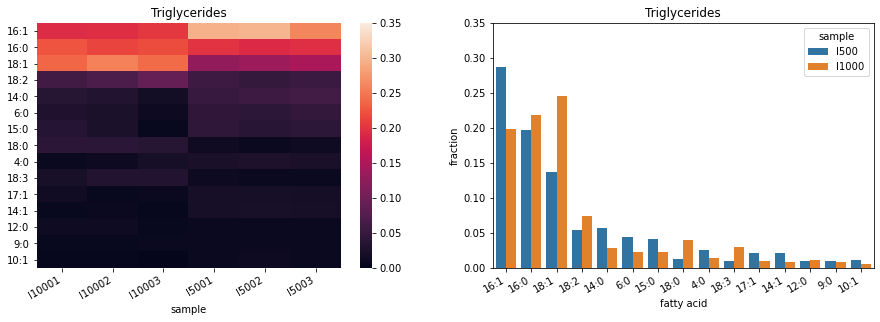

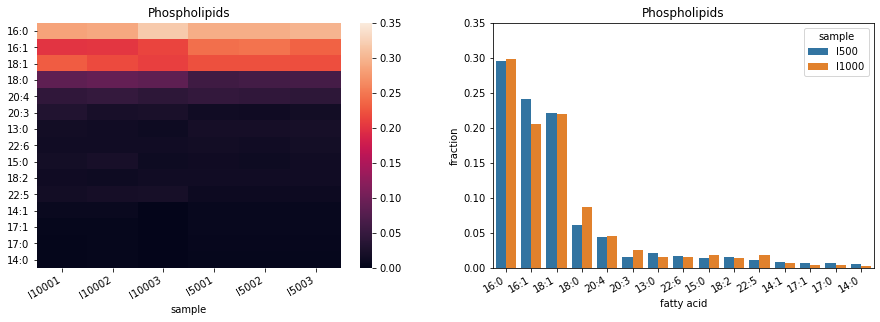

In [49]:
graph_fatty_acids(areas_tg, 'Triglycerides')
graph_fatty_acids(areas_phospho, 'Phospholipids')

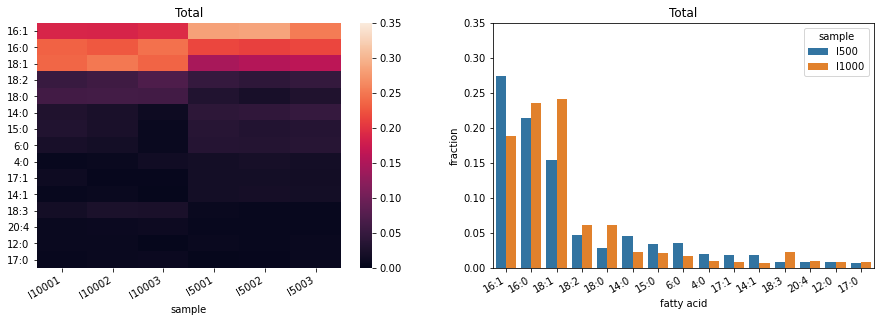

In [50]:
graph_fatty_acids(areas_total, 'Total')

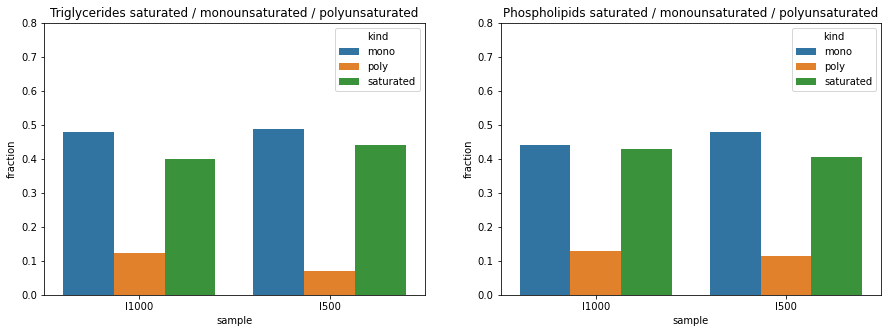

In [51]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
graph_saturation(areas_tg, 'Triglycerides')
plt.subplot(1, 2, 2)
graph_saturation(areas_phospho, 'Phospholipids')

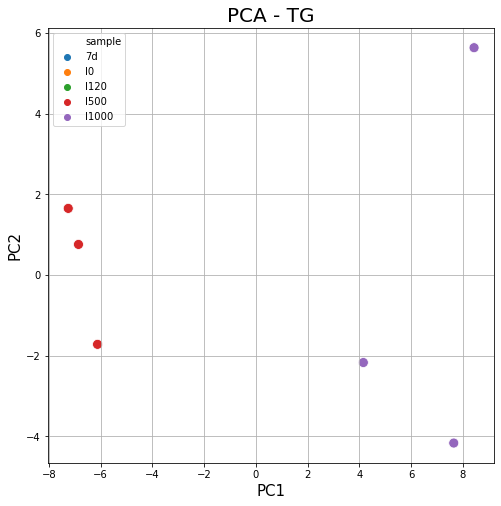

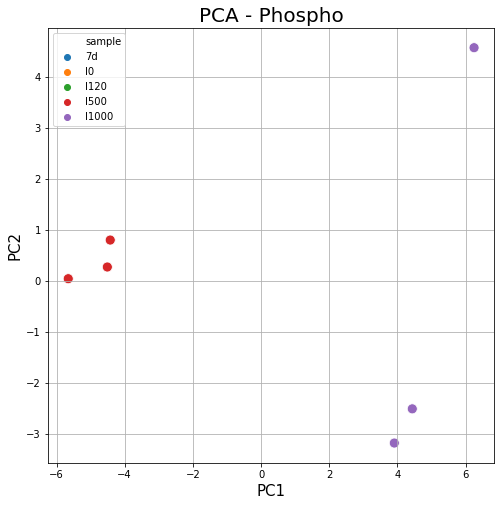

In [52]:
loading_vectors_tg, pca_tg = run_pca(areas_tg)
graph_pca(pca_tg, 'TG')
loading_vectors_phospho, pca_phospho = run_pca(areas_phospho)
graph_pca(pca_phospho, 'Phospho')